# Imports

In [29]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits, ascii
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import time
import copy
import sbi
from sbi import utils as utils
from sbi.inference import infer
import torch

from minot.ClusterTools import map_tools
import pitszi

# Parameters

In [2]:
output_dir = '/Users/radam/Desktop/PITSZItestSBI/'

In [3]:
#----- Physical model parameters
# Global
redshift = 0.5
M500 = 1e15*u.Msun
RA, Dec   = 30*u.deg, 55*u.deg
dRA, dDec = 30*u.arcsec, -10*u.arcsec
axis_q1, axis_q2 = 0.7, 0.7
euler_1, euler_2, euler_3 = 0*u.deg, 90*u.deg, 35*u.deg

# Fluctuations
fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 800*u.kpc
fluct_statistics = 'gaussian'
fluct_seed = None

In [4]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM = 15*u.arcsec

# Transfer function
karcsec = np.linspace(0, 1/beam_FWHM.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov = 1/(7*60)
TF = {'k':karcsec, 'TF':1-np.exp(-karcsec.to_value('arcsec-1')/kfov)}

# Mask
mask_Ntheta500 = 1

# Noise
noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1
noise_r = lambda r_arcsec: (1 + np.exp((r_arcsec-200)/80))
noise_seed = None

In [5]:
#----- Analysis parameters
# Pk measurement
Nbins_pk = 10
scale_bins = 'log'
kmin_pk = 1/(60*5)*u.arcsec**-1
kmax_pk = 1/(2*beam_FWHM.to('arcsec'))

# weight definition
method_w8_radial  = True
method_w8_smooth  = 20*u.arcsec
method_w8_beam    = True
method_w8_TF      = False

# methodology
method_data_deconv = False
method_use_covmat  = False
method_parallel    = False

method_setup_overwrite = False

# SBI parameters

# Data simulation

In [6]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA+dRA, Dec=Dec+dDec, redshift=redshift, M500=M500, silent=True, output_dir=output_dir)
mock.set_pressure_profile_universal_param('A10MD')
mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'statistics':fluct_statistics,
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}
mock.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                    'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}
if fluct_seed is not None: mock.model_seed_fluctuation = fluct_seed

mock.map_center = SkyCoord(RA, Dec, frame="icrs")
mock.map_fov    = [6, 5]*u.arcmin
mock.map_reso  = 5*u.arcsec
mock.los_reso  = 50*u.kpc
mock.los_size  = 2*u.Mpc
mock.R_truncation = mock.R500*10

mock.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 73 , 59 , 41
   Pixel size :      31.4     kpc ;     5.0      arcsec
   Fov size :  [   2295.2   ,   1855.0   ] kpc ; [   6.083    ,   4.917    ] arcmin
   L.o.S. resolution :         50.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (30., 55.)>
   k min/max projected :       0.002740  /  0.098630   1/arcsec
   k min/max projected :       0.000436  /  0.015685   1/kpc
   k min/max L.o.S. (eq.) :    0.003067  /  0.061349   1/arcsec
   k min/max L.o.S. :          0.000488  /  0.009756   1/kpc
   k max Nyquist :             0.061349   1/arcsec
   k max Nyquist :             0.009756   1/kpc


In [7]:
#===== Initiate a data object and fake data
#----- Init with the mock
data = pitszi.Data(mock.get_sz_map(), mock.get_map_header())
data.output_dir = output_dir

#----- set basic IRFs
data.psf_fwhm              = beam_FWHM
data.transfer_function     = TF
data.noise_model = [noise_r, noise_k]

#----- Define the mask
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, (RA+dRA).to_value('deg'), (Dec+dDec).to_value('deg'))
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 
data.mask = mask

#----- Define the noise properties
data.noise_mc = data.get_noise_monte_carlo_from_model(Nmc=1000, center=mock.get_map_center())
data.noise_rms = data.get_noise_rms_from_model(Nmc=1000, center=mock.map_center)
if os.path.exists(data.output_dir+'/data_image_noise_covariance_matrix.pkl'):
    data.load_noise_covariance(data.output_dir+'/data_image_noise_covariance_matrix.pkl')
else:
    data.noise_covmat = data.get_noise_covariance_from_model(Nmc=1000)
    data.save_noise_covariance(data.output_dir+'/data_image_noise_covariance_matrix.pkl')

#----- Mock the data
img = data.set_image_to_mock(mock, model_no_fluctuations=False, 
                             noise_origin='model', noise_center=mock.get_map_center(), noise_seed=noise_seed)

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                           Data                             
------------------------------------------------------------


/var/folders/vn/s8_3jv496gz7jpw5mh082r8r0000gn/T/ipykernel_8313/3583775950.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1
/var/folders/vn/s8_3jv496gz7jpw5mh082r8r0000gn/T/ipykernel_8313/3583775950.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1
/var/folders/vn/s8_3jv496gz7jpw5mh082r8r0000gn/T/ipykernel_8313/3583775950.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1


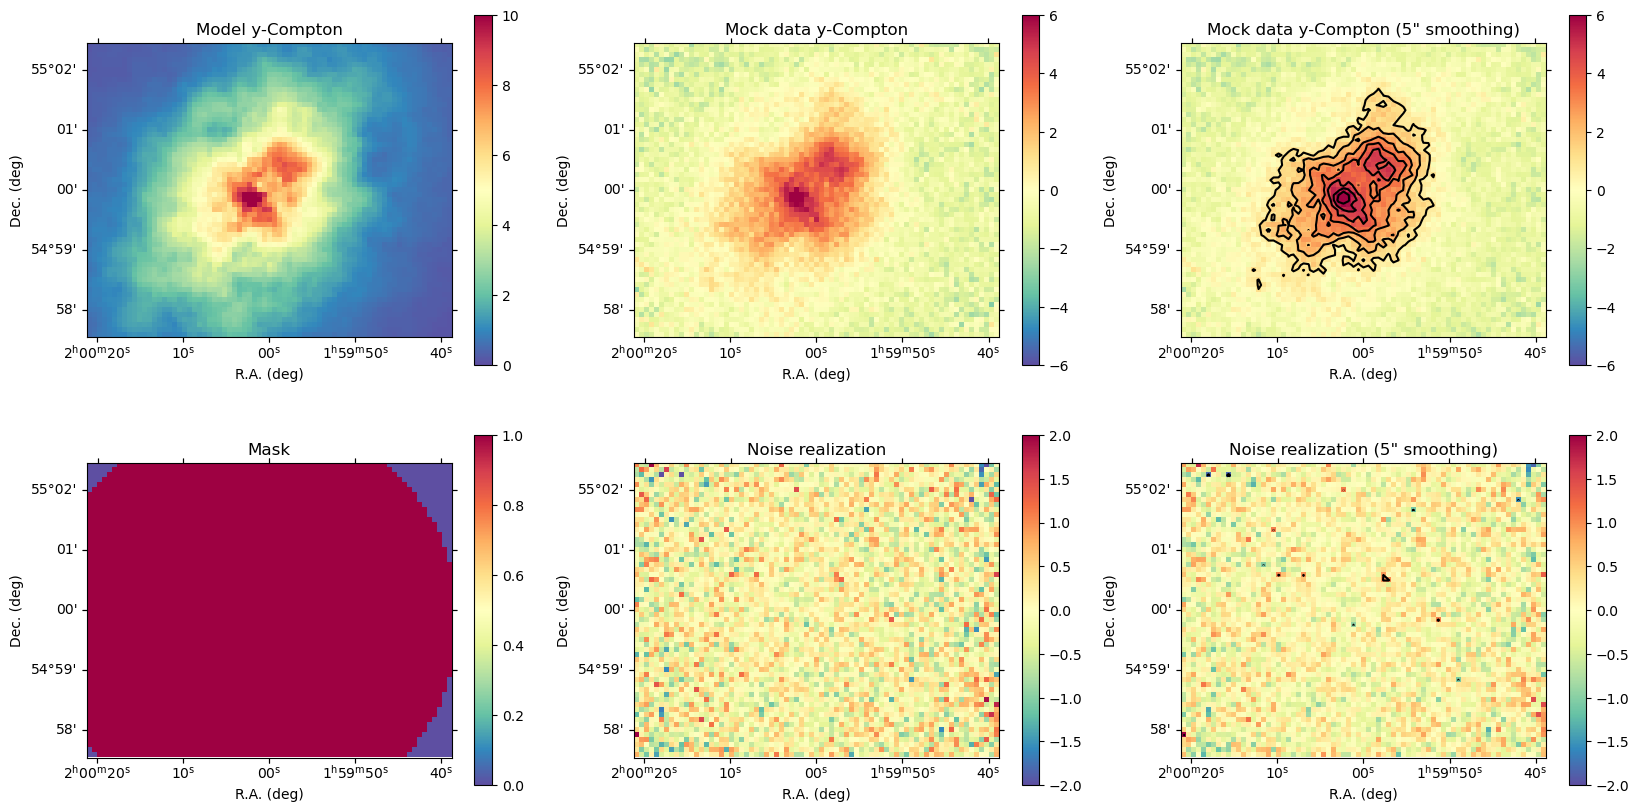

In [8]:
visu_smooth = 5

#===== Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(20, 10))

ax = plt.subplot(2, 3, 1, projection=WCS(data.header))
plt.imshow(mock.get_sz_map(no_fluctuations=False)*1e5, cmap='Spectral_r', vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 2, projection=WCS(data.header))
plt.imshow(data.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 3, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 4, projection=WCS(data.header))
plt.imshow(data.mask, cmap='Spectral_r', vmin=0, vmax=1)
cb = plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 5, projection=WCS(data.header))
plt.imshow(data.noise_mc[0]*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
plt.title('Noise realization')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 6, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[-3,3], colors='k')
plt.title('Noise realization ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

# CIB data augmentation devs

In [9]:
def simu_cib(header, beam_FWHM, TF, Nsim=1000, Scut_high=100, Scut_low=0.0):
    y2mjy = -12e3
    sigma2fwhm = 2*np.sqrt(2*np.log(2))

    RA0, Dec0 = header['CRVAL1'], header['CRVAL2']
    ramap, decmap = map_tools.get_radec_map(header)
    src = np.zeros((Nsim, header['NAXIS2'], header['NAXIS1']))
    
    path     = '/Users/radam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/sides-public-release-main/cats/CIB_cat_sim/'
    ignored  = {".DS_Store"}
    catfiles = [x for x in os.listdir(path) if x not in ignored]
    np.random.shuffle(catfiles)
    
    for imc in range(Nsim):
        if Nsim>1 and imc % 10 == 0: print(imc, '/', Nsim)
        hdul = fits.open(path+catfiles[imc])
        cat_imc = hdul[1].data
        hdul.close()
        w1 = cat_imc['SNIKA2000']*1e3 > Scut_low
        w2 = cat_imc['SNIKA2000']*1e3 < Scut_high
        cat_imc = cat_imc[w1*w2]
        
        src_imc = np.zeros((header['NAXIS2'], header['NAXIS1']))
        for isrc in range(len(cat_imc)):
            dist_map = map_tools.greatcircle(ramap, decmap, RA0+cat_imc['ra'][isrc], Dec0+cat_imc['dec'][isrc])
            flux = cat_imc['SNIKA2000'][isrc]*1e3
            src_imc += flux*np.exp(-dist_map**2/2/(beam_FWHM.to_value('deg')/sigma2fwhm)**2)
                
        img_conv = pitszi.utils_pk.apply_transfer_function(src_imc, header['CDELT2']*3600, beam_FWHM.to_value('arcsec'), TF)
        src[imc,:,:] = img_conv
                
    return src/y2mjy

In [10]:
cib_mc = simu_cib(data.header, beam_FWHM, TF, Nsim=100, Scut_high=100, Scut_low=0.001)

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


In [11]:
model = copy.deepcopy(mock)

In [17]:
cl_Finfer = pitszi.InferenceFluctuation(data, model,
                                        nuisance_bkg_mc1=cib_mc*0.1,
                                        method_use_covmat=False, silent=False,
                                        output_dir=output_dir)

#----- Define binning
cl_Finfer.kbin_min   = kmin_pk
cl_Finfer.kbin_max   = kmax_pk
cl_Finfer.kbin_Nbin  = Nbins_pk
cl_Finfer.kbin_scale = scale_bins

#----- Weight definition
RA0, Dec0 = data.header['CRVAL1'], data.header['CRVAL2']
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, RA0, Dec0)*60
roi = dist_map*0
roi[dist_map < 3] = 1
cl_Finfer.set_method_w8(roi_mask=roi,
                        apply_radial_model=method_w8_radial, 
                        conv_radial_model_beam=method_w8_beam, 
                        conv_radial_model_TF=method_w8_TF, 
                        remove_GNFW_core=True,
                        smooth_FWHM=method_w8_smooth)
    
#----- Setup
cl_Finfer.pk_setup(Nmc=100)

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                 Fluctuation Inference                      
------------------------------------------------------------
----- Checking the inputs -----
      - Data1, data2, and model projection OK.
----- Running the setup -----
The setup is necessary for inference on the power spectrum:
- Compute map resolution and k binning information         
- compute ymap residual to be used for Pk extraction       
- compute the smooth model                                 
- extract Pk data, reference model and noise properties    
- compute conversion from Pk 2d to Pk3d   

In [18]:
k2d, pk2d_data = cl_Finfer.get_pk2d_data(physical=True)

In [24]:
dlnc = pitszi.utils_pk.pk_data_augmentation(k2d, cl_Finfer._pk2d_bkg_mc, Nsim=100, method='LogNormCov')
dnni = pitszi.utils_pk.pk_data_augmentation(k2d, cl_Finfer._pk2d_bkg_mc, Nsim=100, method='NearNeighborsItpl', n_nearest=99)

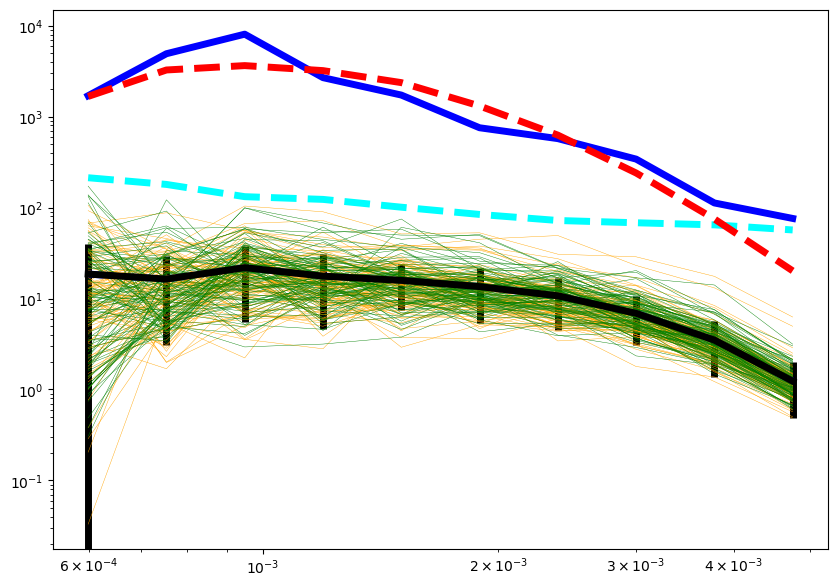

In [26]:
plt.figure(figsize=(10,7))
plt.loglog(k2d, pk2d_data, color='blue', lw=5)
plt.errorbar(cl_Finfer._kctr_kpc, cl_Finfer._pk2d_bkg, cl_Finfer._pk2d_bkg_rms, color='k', lw=5)
plt.plot(cl_Finfer._kctr_kpc, cl_Finfer._pk2d_bkg, color='blue', ls='--', lw=5)
plt.plot(cl_Finfer._kctr_kpc, cl_Finfer._pk2d_noise, color='cyan', ls='--', lw=5)
plt.plot(cl_Finfer._kctr_kpc, cl_Finfer._pk2d_modref, color='r', ls='--', lw=5)
for i in range(100): plt.loglog(cl_Finfer._kctr_kpc, cl_Finfer._pk2d_bkg_mc[i], color='orange', lw=0.3)
for i in range(100): plt.loglog(k2d, dlnc[i], color='green', lw=0.3)
#for i in range(100): plt.loglog(k2d, dnni[i], color='r', lw=0.3)
plt.xscale('log')
plt.yscale('log')

# SBI simulator

In [27]:
def simulator_pk2d(parameters):

    #========== Modify the cluster model
    cl_Finfer.model.model_seed_fluctuation = np.random.randint(0, 2**32 - 1)
    cl_Finfer.model.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                                  'statistics': 'gaussian',
                                                  'Norm': parameters[0],
                                                  'slope': -11/3,
                                                  'Linj': parameters[1]*u.kpc,
                                                  'Ldis': 1*u.kpc}
    
    #========== Extract the new pk2d
    cl_Finfer.nuisance_Anoise = 0
    cl_Finfer.nuisance_Abkg   = 0
    k2d, pk2d_sz = cl_Finfer.get_pk2d_model_brute(physical=True)
    
    #========== add noise and CIB
    CIB   = pitszi.utils_pk.pk_data_augmentation(k2d, pk2d_bkg_mc.value,   Nsim=1, method='LogNormCov')[0]
    noise = pitszi.utils_pk.pk_data_augmentation(k2d, pk2d_noise_mc.value, Nsim=1, method='LogNormCov')[0]
    pk2d = pk2d_sz.value + noise + CIB
    
    # === Security patch to get ride of NaN and Inf
    if not np.all(np.isfinite(pk2d)):
        print(f"[Warning] simulator: NaN or Inf detected for parameters={parameters}. Correction applied.")
        pk2d = np.nan_to_num(pk2d, nan=0.0, posinf=0.0, neginf=0.0)
    
    return pk2d

# SBI training

In [30]:
#===== Prior
num_dim = 2  # uniform prior with 2 parameters
prior = sbi.utils.BoxUniform(low=torch.FloatTensor([0., 0.]),
                             high=torch.FloatTensor([1., 2000.]))

In [32]:
retraining = False

# === SNPE with basic Pk2d simulator
# list of the N_simu on which to train a neural network
list_n_simu_sbi = [100, 1000]
for n_simu_sbi in list_n_simu_sbi:
    
    posterior_filename = output_dir+f"NPE_"f"{n_simu_sbi}.pt"

    if os.path.exists(posterior_filename) and retraining==False:
        print(f">> Posterior for {n_simu_sbi} simulations already exists, skipping.")
        continue

    print(f">> Computing posterior for {n_simu_sbi} simulations...")
    posterior_pk2d = infer(simulator_pk2d, prior, method='SNPE', num_simulations=n_simu_sbi)
    torch.save(posterior_pk2d, posterior_filename)
    print(f">> Posterior for {n_simu_sbi} simulations saved.")

>> Computing posterior for 100 simulations...


  0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 112 epochs.>> Posterior for 100 simulations saved.
>> Computing posterior for 1000 simulations...


  0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 217 epochs.>> Posterior for 1000 simulations saved.


# SBI fit

In [33]:
Nsimu = 10000

observavble = cl_Finfer.get_pk2d_data(physical=True)[1]

posterior = torch.load(output_dir+f"NPE_"f"{n_simu_sbi}.pt")
samples_sbi = posterior.sample((10000,), x=observavble).numpy()

/var/folders/vn/s8_3jv496gz7jpw5mh082r8r0000gn/T/ipykernel_8313/132732967.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  posterior = torch.load(output_dir+f"NPE_"f"{n_s

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

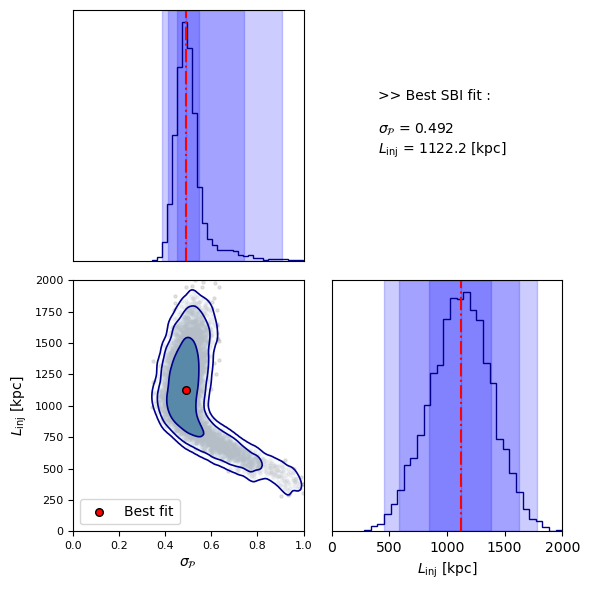

In [35]:
from scipy.stats import norm, gaussian_kde, skewnorm
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(6, 6))

# ==========================================
plt.subplot(2, 2, 3)

# levels to plot
list_levels = [0, 0.68, 0.95, 0.99]

# === Load fit ===
samples = np.array(samples_sbi)
x = samples[:, 0]
y = samples[:, 1]
    
best_fit = np.median([x, y], axis=1)
    
# KDE
kde = gaussian_kde(np.vstack([x, y]))

# Grid
margin_x = (max(x) - min(x)) * 0.1
margin_y = (max(y) - min(y)) * 0.1
    
x_grid = np.linspace(min(x) - margin_x, max(x) + margin_x, 100)
y_grid = np.linspace(min(y) - margin_y, max(y) + margin_y, 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# Get density thresholds for contour levels
Z_flat = Z.flatten()
Z_sorted = np.sort(Z_flat)[::-1]
cumsum = np.cumsum(Z_sorted)
cumsum /= cumsum[-1]
thresholds = [Z_sorted[np.argmax(cumsum >= l)] for l in list_levels]

# Background points
plt.scatter(x, y, color="gray", alpha=0.2, s=5)

# Contourf for filled confidence
plt.contourf(X, Y, Z, levels=sorted(thresholds), cmap="Blues", alpha=0.6)
# Contour lines
plt.contour(X, Y, Z, levels=sorted(thresholds), colors="darkblue", linewidths=1.2)

# Fitted best fit
plt.scatter(best_fit[0], best_fit[1], color="red", edgecolors="black", 
            s=30, label="Best fit", zorder=5)

# Style
plt.tick_params(labelsize=8)
#plt.grid(True, linestyle="--", alpha=0.3)

plt.ylabel(r"$L_{\mathrm{inj}}$ [kpc]", fontsize=10)
plt.xlabel(r"$\sigma_\mathcal{P}$", fontsize=10)
plt.xlim(0, 1)
plt.ylim(0, 2000)
plt.legend()

# ===========================================
plt.subplot(2, 2, 1)
plt.hist(x, bins=30, density=False, color="darkblue", alpha=1, histtype = 'step')
plt.xlim(0, 1)
plt.axvline(best_fit[0], color="red", linestyle="-.", label="Median")
plt.xticks([])
plt.yticks([])

# condidence levels
for level in list_levels:
    lower = np.percentile(x, (1 - level) / 2 * 100)
    upper = np.percentile(x, (1 + level) / 2 * 100)
    plt.axvspan(lower, upper, color="blue", alpha=0.2)
    
# ===========================================
plt.subplot(2, 2, 4)
plt.hist(y, bins=30, density=False, color="darkblue", alpha=1, histtype = 'step')
plt.xlim(0, 2000)
plt.xlabel(r"$L_{\mathrm{inj}}$ [kpc]", fontsize=10)
plt.axvline(best_fit[1], color="red", linestyle="-.", label="Median")
plt.yticks([])

# condidence levels
for level in list_levels:
    lower = np.percentile(y, (1 - level) / 2 * 100)
    upper = np.percentile(y, (1 + level) / 2 * 100)
    plt.axvspan(lower, upper, color="blue", alpha=0.2)

# ===========================================

plt.subplot(2, 2, 2)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.text(0.2, 0.35, ">> Best SBI fit : \n\n" r"$\sigma_\mathcal{P}$ = " + f"{best_fit[0]:.3f} \n" +  r"$L_{{\rm inj}}$ = " + f"{best_fit[1]:.1f} [kpc] \n")# + r"<$N_{simu}$ = " + f"{Nsimu:d}>")

plt.tight_layout()